In [128]:
import sys
import h5py
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import matplotlib
# matplotlib.use('svg')
import matplotlib.pyplot as plt
# get functions from other notebooks
%run /tigress/kendrab/analysis-notebooks/loss_fns.ipynb
%run /tigress/kendrab/analysis-notebooks/metrics.ipynb
%run /tigress/kendrab/analysis-notebooks/preproc_utils.ipynb
%run /tigress/kendrab/analysis-notebooks/eval_utils.ipynb

### Load data to try it out

In [129]:
padding_length = 10  # amount of data on each side of each segment for additional info
stride = 10  # size (and therefore spacing) of each segment
input_length = stride + 2*padding_length

readpaths = ['/tigress/kendrab/06022023/'+"100samples_idx50_bxbybzjyvz.hdf5"]

idx_list = []  # to keep track of which file what sample came from
s_list = []
bx_list = []
by_list = []
bz_list = []
jy_list = []
vz_list = []
x0_list = []
x1_list = []
topo_list = []

for idx, filepath in enumerate(readpaths):
    with h5py.File(filepath, 'r') as file:
        idx_list += [np.array([idx for i in bx]) for bx in file['bx_smooth'][:]]  # check this structure!!!
        s_list += list(file['s'][:])
        bx_list += list(file['bx_smooth'][:])
        by_list += list(file['by'][:])
        bz_list += list(file['bz_smooth'][:])
        jy_list += list(file['jy'][:])
        vz_list += list(file['vz'][:]) 
        x0_list += list(file['x0'][:])
        x1_list += list(file['x1'][:])
        topo_list_tmp = list(file['topo'][:])
        for i in range(len(topo_list_tmp)):  # I tried to vectorize this but I didn't get it to work
            topo_list_tmp[i] = topo_list_tmp[i] % 2  # cat 0,2 are not plasmoids, cat 1,3 are
            topo_list_tmp[i] = keras.utils.to_categorical(topo_list_tmp[i], num_classes=2)
        topo_list += topo_list_tmp

# chunk into sliding windows (put fn into preproc_utils)
# NOTE TOPO HAS DIFFERENT SEGMENT LENGTHS THAN THE INPUTS (stride vs. 2*padding+stride)
idx = batch_unpadded_subsects(idx_list, padding_length, stride)
s = batch_subsects(s_list, input_length, stride).reshape(-1, input_length, 1)
bx = batch_subsects(bx_list, input_length, stride).reshape(-1, input_length, 1)
by = batch_subsects(by_list, input_length, stride).reshape(-1, input_length, 1)
bz = batch_subsects(bz_list, input_length, stride).reshape(-1, input_length, 1)
jy = batch_subsects(jy_list, input_length, stride).reshape(-1, input_length, 1)
vz = batch_subsects(vz_list, input_length, stride).reshape(-1, input_length, 1)
x0 = batch_unpadded_subsects(x0_list, padding_length, stride)
x1 = batch_unpadded_subsects(x1_list, padding_length, stride)
topo = batch_unpadded_subsects(topo_list, padding_length, stride)

### Load the pretrained model

In [130]:
loss_fn = keras.losses.CategoricalCrossentropy()
loss = gen_loss_per_pt(loss_fn=loss_fn)
model = keras.models.load_model("/tigress/kendrab/analysis-notebooks/model_outs/29-03-23/samples/delta135716_modelfile.h5", custom_objects={'loss_per_pt':
loss})

### See how it do

In [131]:
print("Testing performance")
test_topo_pred = model(inputs={'bx': bx, 'by': by, 'bz': bz, 'jy': jy, 'vz': vz}, training=False)
test_1d = np.argmax(topo.reshape(-1,2), axis=1) # for confusion matrix
test_1d_pred = np.argmax(test_topo_pred.numpy().reshape(-1,2), axis=1)  
num_per_cat = [np.sum(topo[...,i] == 1) for i in range(2)]
print(f"cat_breakdown\t\t{num_per_cat}")
print([np.max(topo[:,:,i]) for i in range(2)])
print([np.max(test_topo_pred[:,:,i]) for i in range(2)])
for i in range(2):
    acc = gen_metric_per_cat(cat_idx=i)(tf.convert_to_tensor(topo), test_topo_pred)
    print(f"Category {i} had recall {acc}")    


Testing performance
cat_breakdown		[47587, 993]
[1.0, 1.0]
[0.999995, 0.5050631]
Category 0 had recall 1.0
Category 1 had recall 0.0010070493444800377


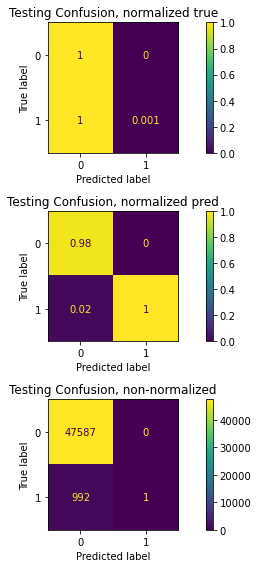

In [132]:
%matplotlib inline
fig, ax = plt.subplots(3, figsize=(8,8))
ax[0].set(title="Testing Confusion, normalized true")
ax[1].set(title="Testing Confusion, normalized pred")
ax[2].set(title="Testing Confusion, non-normalized")
cf_test_t = ConfusionMatrixDisplay(confusion_matrix(test_1d, test_1d_pred, normalize='true'))
cf_test_p = ConfusionMatrixDisplay(confusion_matrix(test_1d, test_1d_pred, normalize='pred'))
cf_test = ConfusionMatrixDisplay(confusion_matrix(test_1d, test_1d_pred))

cf_test_t.plot(ax=ax[0])
cf_test_p.plot(ax=ax[1])
cf_test.plot(ax=ax[2])

fig.tight_layout()
plt.show()